# Notebook for ZFOURGE CDFS Bolometric Luminosity Functions

### Import and setup

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.cosmology import FlatLambdaCDM, z_at_value
import astropy.units as u

data = pd.read_csv('../DATA/ZFOURGE/CDFS/CDFS_MAIN.csv')
df = pd.DataFrame(data)
use_mask = df['Use']
LIR_mask = df['LIR']
df = df[df['Use'] == 1] # 13,299
df = df[df['LIR'] > 0] # 8,486

redshift_bins = [(0, 0.3), (0.3, 0.45), (0.45, 0.6), (0.6, 0.8), 
                 (0.8, 1.0), (1.0, 1.2), (1.2, 1.7), (1.7, 2.0),
                 (2.0, 2.5), (2.5, 3.0), (3.0, 4.2), (4.2, 5.0),
                 (5.0, 6.0)] # redshift bins
survey_area = 0.03556 # survey area in square degrees
min_count = 5 # minimum number of galaxies in a bin
all_lum_bins = [20, 20, 20, 15,
                15, 15, 15, 15,
                15, 15, 15, 15,
                15] # number of luminosity bins in each redshift bin
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
percentiles = [25, 25, 25, 25,
               30, 30, 30, 30,
               40, 40, 60, 45,
               30] # percentiles for each redshift bin

df = df[(df['zpk'] >= redshift_bins[0][0]) & (df['zpk'] <= redshift_bins[-1][1])] # 8,469

### Quiescent vs Starforming

In [ ]:
filename = '../DATA/ZFOURGE/CDFS/CDFS_FLUX.tsv'
data = pd.read_csv(filename, sep='\t', skiprows=117)
uvj = pd.DataFrame(data)
uvj = uvj.iloc[2:]
uvj = uvj.apply(pd.to_numeric, errors='coerce')
uvj['Use'] = use_mask
uvj['LIR'] = LIR_mask
uvj = uvj[uvj['Use'] == 1]
uvj = uvj[uvj['LIR'] > 0]

U = uvj['FU'] # uJy
V = uvj['FV'] # uJy
J = uvj['FJ'] # uJy

U_ab = 25 - 2.5*np.log10(U) # apparent magnitude -> AB magnitude
V_ab = 25 - 2.5*np.log10(V) # apparent magnitude -> AB magnitude
J_ab = 25 - 2.5*np.log10(J) # apparent magnitude -> AB magnitude

U_V = U_ab - V_ab
V_J = V_ab - J_ab

mask_q = (U_V > 1.3) & (V_J < 1.6) & (U_V > 0.88*V_J+0.59)
print(f'Quiescent: {mask_q.sum()}')
print(f'Star-forming: {len(U_V) - mask_q.sum()}')

# df = df[mask_q] # 675
df = df[~mask_q] # 7,811

plt.scatter(V_J[mask_q], U_V[mask_q], s=1, label='Quiescent', color='red')
plt.scatter(V_J[~mask_q], U_V[~mask_q], s=1, label='Star-forming', color='blue')
plt.xlabel('$V - J$')
plt.ylabel('$U - V$')
plt.xlim(0, 2.5)
plt.ylim(0, 2.5)
plt.hlines(1.3, 0, 0.8, colors='red', linestyles='dashed')
plt.vlines(1.6, 2, 2.5, colors='red', linestyles='dashed')
plt.plot([0.8, 1.6], [1.3, 2.0], color='red', linestyle='dashed')
plt.legend()
plt.show()

### Luminosity vs Redshift

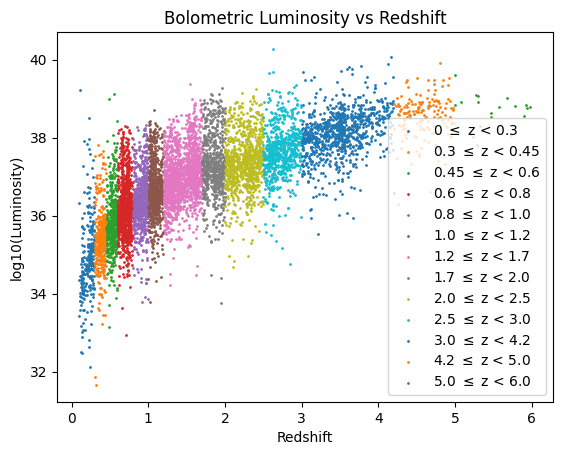

In [31]:
luminosity = df['LIR'].copy().values # solar luminosities
luminosity *= 3.828 * 10 ** 26 # solar luminosity -> Watts
z = df['zpk'].values # redshift

for z_start, z_end in redshift_bins:
    mask = (z >= z_start) & (z < z_end)
    plt.scatter(z[mask], np.log10(luminosity[mask]), s=1, label=f'{z_start} $\leq$ z < {z_end}')
plt.title('Bolometric Luminosity vs Redshift')
plt.ylabel('log10(Luminosity)')
plt.xlabel('Redshift')
plt.legend()
plt.show()

### Luminosity-distance relationship

1) Calculate the maximum distance using given luminosity, $L_{IR}$, and the flux limit of survey, $F_{lim}$. This effectively calculates the maximum possible distance of the galaxy given we know it's instrinsic luminosity but if it's flux were at the survey limit.

$$
D_{max} = \sqrt{\frac{L}{4 \pi F_{lim}}}
$$


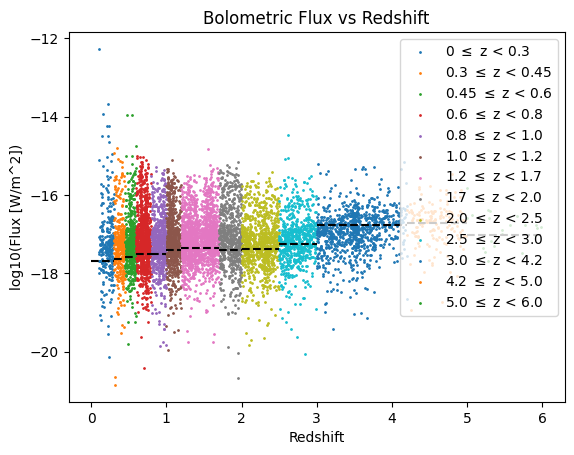

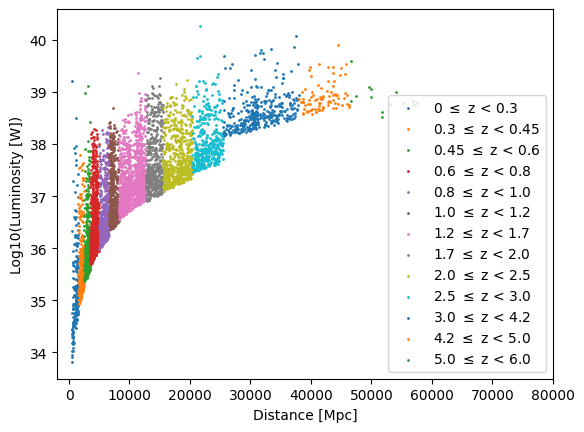

In [32]:
# Luminsity distance of galaxies
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
d_L = cosmo.luminosity_distance(z).to('m').value # m

F_bol = luminosity / (4 * np.pi * d_L ** 2) # W/m^2

F_lims = []
for (z_start, z_end), perc in zip(redshift_bins, percentiles):
    mask_z = (z >= z_start) & (z < z_end)
    p = np.percentile(F_bol[mask_z], perc) # % of the data above perc
    # p = ((0.003 * (10 ** -29)) * 10 ** 14) # mJy -> W/m^2/Hz -> W/m^2
    F_lims.append(p)
    mask_f = F_bol <= p
    luminosity[mask_f & mask_z] = 0
    plt.scatter(z[mask_z], np.log10(F_bol[mask_z]), s=1, label=f'{z_start} $\leq$ z < {z_end}')
    plt.hlines(np.log10(p), z_start, z_end, color='black', linestyle='--')
plt.title('Bolometric Flux vs Redshift')
plt.ylabel('log10(Flux [W/m^2])')
plt.xlabel('Redshift')
plt.legend()
plt.show()

# Remove galaxies with no luminosity
mask_l = luminosity > 0
luminosity = luminosity[mask_l]
z = z[mask_l]
d_L = d_L[mask_l]
    
# Maximum distance of galaxies (eq 2)
dmaxs = np.zeros(len(luminosity))
for (z_start, z_end), F_lim in zip(redshift_bins, F_lims):
    mask_z = (z >= z_start) & (z < z_end)
    dmaxs[mask_z] = np.sqrt(luminosity[mask_z] / (4 * np.pi * F_lim))

z_lim = z_at_value(cosmo.luminosity_distance, dmaxs * u.m)

colours = ['cyan', 'orange', 'lime', 'indianred', 'violet', 'tan', 'cyan', 'orange', 'lime', 'indianred', 'violet', 'tan', 'cyan']
for (z_start, z_end), c in zip(redshift_bins, colours):
    mask_z = (z >= z_start) & (z < z_end)
    plt.scatter(d_L[mask_z]*3.241*10**-23, np.log10(luminosity[mask_z]), s=1, label=f'{z_start} $\leq$ z < {z_end}')
    # plt.scatter(dmaxs[mask_z]*3.241*10**-23, np.log10(luminosity[mask_z]), s=1, c=c)
plt.xlabel('Distance [Mpc]')
plt.ylabel('Log10(Luminosity [W])')
plt.xlim(-2000, 80000)
plt.legend()
plt.show()

### Luminosity Bin Limits vs Maximum Redshift

This shows that when calculating the maximum possible distance, to eventually calculate volume, the luminosities no longer follow the `luminosity_distance` limit and instead follow the `comoving_distance` limit. This must be corrected by excluding sources below the `luminosity_distance` limit.

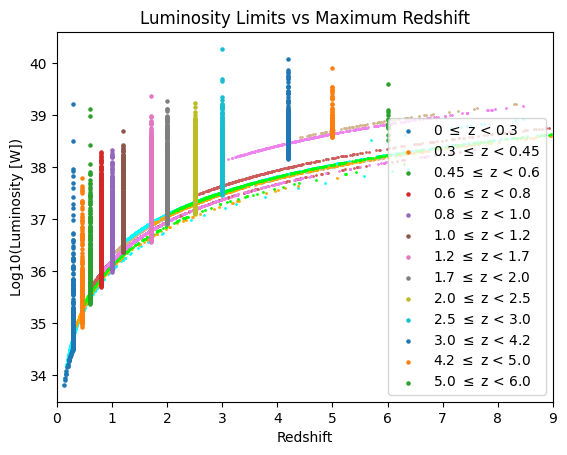

In [33]:
colours = ['cyan', 'orange', 'lime', 'indianred', 'violet', 'tan', 'cyan', 'orange', 'lime', 'indianred', 'violet', 'tan', 'cyan']
for (z_min, z_max), c in zip(redshift_bins, colours):
    mask_z = (z >= z_min) & (z < z_max)
    plt.scatter(z_lim[mask_z], np.log10(luminosity[mask_z]), s=1, c=c)
    
for (z_min, z_max), n_lum_bins, F_lim, c in zip(redshift_bins, all_lum_bins, F_lims, colours):
    mask = (z >= z_min) & (z < z_max)
    
    lum_bin = np.log10(luminosity)[mask]
    
    # Find the maximum distance for the redshift bin
    dmin = cosmo.comoving_distance(z_min).value # Mpc
    dmax = cosmo.comoving_distance(z_max).value # Mpc
    
    # Find the maximum distance for each source
    dmaxs = np.sqrt(luminosity[mask] / (4*np.pi*F_lim)) # meters
    dmaxs *= 3.241 * 10 ** -23 # meters -> Mpc
    
    # Only use luminosity bins that are possible in the redshift range
    d_mask = dmaxs >= dmin
    dmaxs = dmaxs[d_mask]
    lum_bin = lum_bin[d_mask]
        
    # Limit the distance to the maximum distance
    dmaxs[dmaxs > dmax] = dmax
    
    # Find the redshift at the maximum distance
    z_lims = z_at_value(cosmo.comoving_distance, dmaxs * u.Mpc)
    plt.scatter(z_lims, lum_bin, s=5, label=f'{z_min} $\leq$ z < {z_max}')
    
plt.title('Luminosity Limits vs Maximum Redshift')
plt.xlabel('Redshift')
plt.ylabel('Log10(Luminosity [W])')
plt.legend(loc='lower right')
plt.xlim(redshift_bins[0][0], redshift_bins[-1][1]+3)
plt.show()

### Calculate Maximum Volume

Correcting for the above

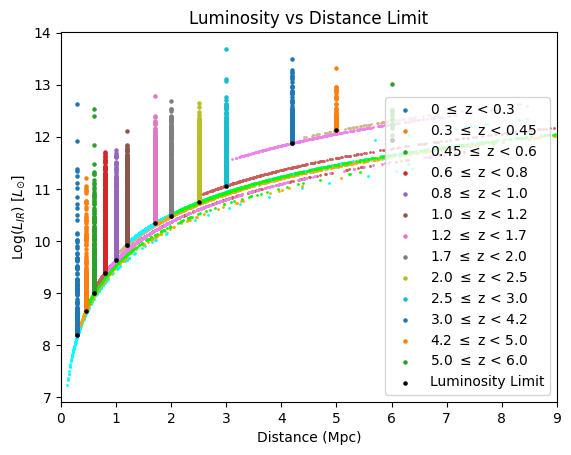

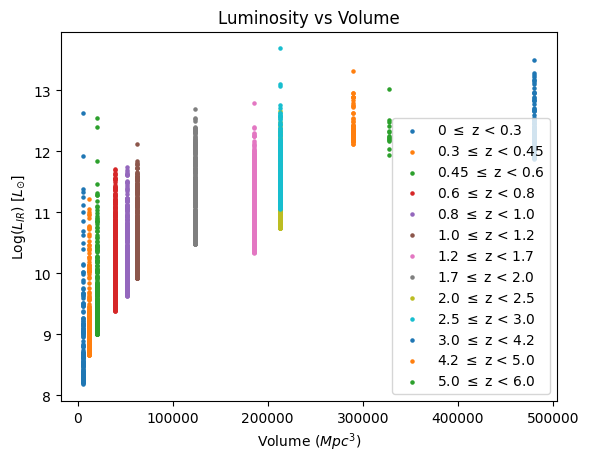

In [34]:
def lum_lim(z_in):
    return (luminosity/(3.83*10**26))[mask][np.argmin(np.abs(z_lim[mask] - z_in))]

all_data = []
min_ls = []
bool_q = []

colours = ['cyan', 'orange', 'lime', 'indianred', 'violet', 'tan', 'cyan', 'orange', 'lime', 'indianred', 'violet', 'tan', 'cyan']
for (z_min, z_max), c in zip(redshift_bins, colours):
    mask_z = (z >= z_min) & (z < z_max)
    plt.scatter(z_lim[mask_z], np.log10(luminosity[mask_z]/(3.83*10**26)), s=1, c=c)
    
for (z_min, z_max), F_lim in zip(redshift_bins, F_lims):
    mask = (z >= z_min) & (z < z_max)
    
    lum_bin = np.log10(luminosity[mask]/(3.83*10**26))
    
    # Calculate the minimum and maximum distance of the redshift bin
    dmin = cosmo.comoving_distance(z_min).value # Mpc
    dmax = cosmo.comoving_distance(z_max).value # Mpc
    
    # Find the maximum distance for each source
    dmaxs = np.sqrt(luminosity[mask] / (4*np.pi*F_lim)) # meters
    dmaxs *= 3.241 * 10 ** -23 # meters -> Mpc
    
    # Distances must be greater than the minimum distance
    d_mask = dmaxs >= dmin
    
    # Lumiosity bins must be greater than or equal to the minimum luminosity (from luminosity distance)
    l = lum_lim(z_max)
    mlim_mask = lum_bin >= np.log10(l)
    min_ls.append(l)
    
    # Apply masks
    dmaxs = dmaxs[d_mask & mlim_mask]
    lum_bin = lum_bin[d_mask & mlim_mask]
    
    # If the maximum distance is greater than the maximum redshift bin distance, set it to the maximum redshift bin distance
    dmaxs[dmaxs > dmax] = dmax
    
    # Calculate the minimum volume of the redshift bin
    vmin = 4/3 * np.pi * dmin**3 # Mpc^3

    # Calculate the maximum volume of each luminosity bin
    vmaxs = 4/3 * np.pi * dmaxs**3 # Mpc^3
    
    # Total volume probed accounting for survey area
    vol = (vmaxs - vmin) * (survey_area / 41253) # Mpc^3
    
    all_data.append([vol, lum_bin])

    z_lims = z_at_value(cosmo.comoving_distance, dmaxs * u.Mpc)
    plt.scatter(z_lims, lum_bin, s=5, label=f'{z_min} $\leq$ z < {z_max}')
    plt.scatter(z_max, np.log10(l), s=5, color='black')

plt.scatter(z_max, np.log10(l), s=5, color='black', label='Luminosity Limit')
plt.title('Luminosity vs Distance Limit')
plt.xlabel('Distance (Mpc)')
plt.ylabel('Log($L_{IR}$) [$L_{\odot}$]')
plt.xlim(redshift_bins[0][0], redshift_bins[-1][1]+3)
plt.legend(loc='lower right')
plt.show()

plt.title('Luminosity vs Volume')
for (v, m), (z_start, z_end) in zip(all_data, redshift_bins):
    plt.scatter(v, m, s=5, label=f'{z_start} $\leq$ z < {z_end}')
plt.xlabel('Volume $(Mpc^3)$')
plt.ylabel('Log($L_{IR}$) [$L_{\odot}$]')
plt.legend()
plt.show()

### Counts Histograms

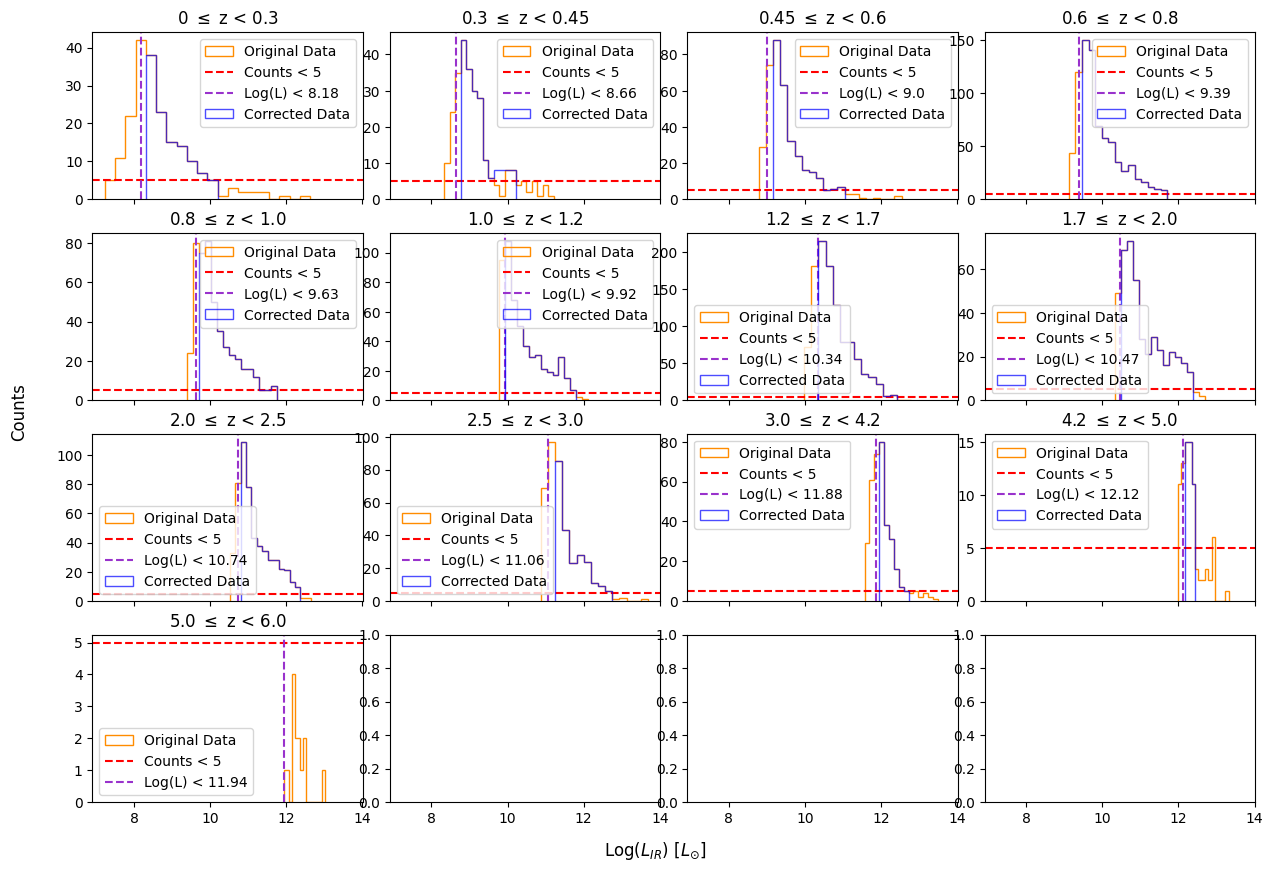

In [35]:
fig, axes = plt.subplots(4, 4, figsize=(15, 10), sharex=True)
bin_edges = []
for (z_start, z_end), (vol, lum), bins, ax, min_l in zip(redshift_bins, all_data, all_lum_bins, axes.flatten(), min_ls):
    
    # Bin the original data per redshift bin
    _, b, _ = ax.hist(np.log10(luminosity/(3.83*10**26))[(z >= z_start) & (z < z_end)], bins=bins, histtype='step', label='Original Data', color='darkorange')
    
    # Bin the new data with the same bins
    c, b = np.histogram(lum, bins=b)
    centers = (b[:-1] + b[1:]) / 2 # bin centers
    
    # Mask the bins with less than the minimum count
    c_mask = c >= min_count
    nci = np.where(np.diff(np.where(c_mask)[0]) != 1)[0] # non-consecutive indices: mask non-consecutive True values
    c_mask[np.where(c_mask)[0][nci + 1]] = False
    
    b = b[1:][c_mask] # this [1:] removes the first bin edge which is impacted by the mask (would be a fraction of the bin width)
    centers = centers[c_mask]
    c = c[c_mask]
    
    # Plot the mask cutoff
    ax.axhline(min_count, color='red', linestyle='--', label=f'Counts < {min_count}')
    ax.axvline(np.log10(min_l), color='darkorchid', linestyle='--', label=f'Log(L) < {round(np.log10(min_l), 2)}')
    ax.set_title(f'{z_start} $\leq$ z < {z_end}')
    
    # Skip if there are no bins
    if len(c) == 0:
        ax.legend()
        bin_edges.append([])
        continue
    
    # Plot the new, corrected data
    ax.hist(centers, b, weights=c, histtype='step', label='Corrected Data', color='blue', alpha=0.7)
    ax.legend()
    bin_edges.append(b)

fig.supylabel('Counts', x=0.07)
fig.supxlabel('Log($L_{IR}$) [$L_{\odot}$]', y=0.05)
plt.subplots_adjust(hspace=0.2, wspace=0.1)
plt.show()

### Luminosity Function

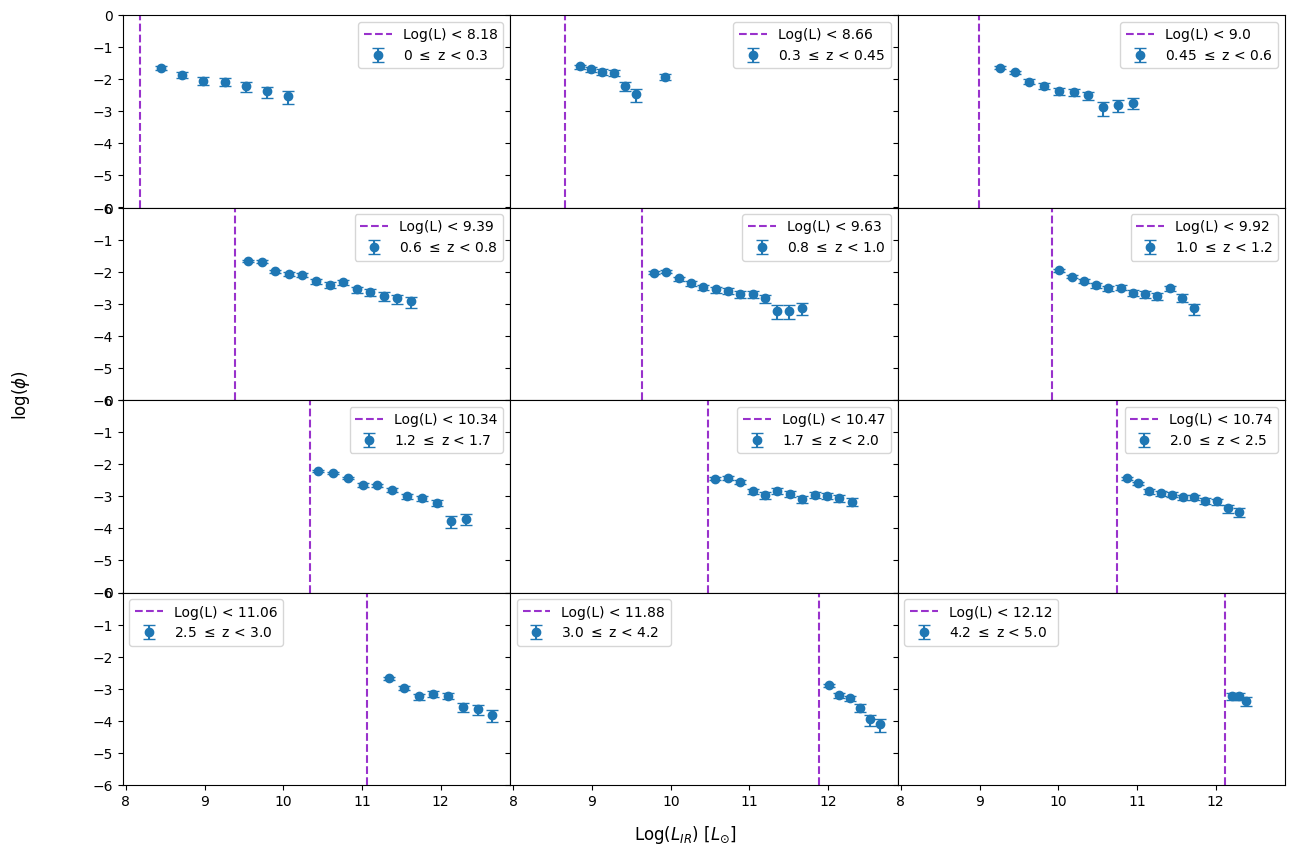

In [40]:
lum_centers, phi, phi_e = [], [], []

# Volume and luminosity are already binned by redshift
for (vol, lum), bin, in zip(all_data, bin_edges):
    
    try:
        delta_log_l = np.diff(bin)[0]
    except IndexError:
        lum_centers.append([])
        phi.append([])
        phi_e.append([])
        continue
    
    lum_centers_z, phi_z, phi_e_z = [], [], []

    # Bin by luminosity
    for lum_start, lum_end in zip(bin, bin[1:]):
        mask = (lum >= lum_start) & (lum < lum_end)
        vol_lum_bin = vol[mask]
        
        # Calculate the number density
        phi_val = (1 / delta_log_l) * np.sum(1 / vol_lum_bin)
        phi_err = (1 / delta_log_l) * np.sqrt(np.sum(1 / (vol_lum_bin ** 2)))
        
        # Save the luminosity bin and number density
        lum_centers_z.append((lum_start + lum_end) / 2)
        phi_z.append(phi_val)
        phi_e_z.append(phi_err)
    
    # Save the luminosity bins and number densities
    lum_centers.append(lum_centers_z)
    phi.append(phi_z)
    phi_e.append(np.array(phi_e_z))

fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)
for (z_start, z_end), lum, p, e, ax, min_l in zip(redshift_bins, lum_centers, phi, phi_e, axes.flatten(), min_ls):
    try:
        yerr = [np.log10(p) - np.log10(p - e), np.log10(p + e) - np.log10(p)]
    except TypeError:
        continue
    ax.errorbar(lum, np.log10(p), yerr=yerr, label=f'{z_start} $\leq$ z < {z_end}', fmt='o', capsize=4)
    ax.axvline(np.log10(min_l), color='darkorchid', linestyle='--', label=f'Log(L) < {round(np.log10(min_l), 2)}')
    ax.set_ylim(-6, 0)
    ax.legend()

fig.supxlabel('Log($L_{IR}$) [$L_{\odot}$]', y=0.05)
fig.supylabel('log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)

### Schechter Fit

0 <= z < 0.3 Function fit:
M_star = 1.01e+01
phi_star = 5.47e-03
alpha = 2.07e+00


0.3 <= z < 0.45 Function fit:
M_star = 9.92e+00
phi_star = 1.15e-02
alpha = 2.15e+00


0.45 <= z < 0.6 Function fit:
M_star = 1.09e+01
phi_star = 1.16e-03
alpha = 3.06e+00


0.6 <= z < 0.8 Function fit:
M_star = 1.16e+01
phi_star = 1.44e-03
alpha = 2.52e+00


0.8 <= z < 1.0 Function fit:
M_star = 1.17e+01
phi_star = 1.13e-03
alpha = 2.37e+00


1.0 <= z < 1.2 Function fit:
M_star = 1.17e+01
phi_star = 1.24e-03
alpha = 2.45e+00


1.2 <= z < 1.7 Function fit:
M_star = 1.19e+01
phi_star = 1.50e-03
alpha = 2.25e+00


1.7 <= z < 2.0 Function fit:
M_star = 1.23e+01
phi_star = 9.70e-04
alpha = 1.96e+00


2.0 <= z < 2.5 Function fit:
M_star = 1.23e+01
phi_star = 5.12e-04
alpha = 2.62e+00


2.5 <= z < 3.0 Function fit:
M_star = 1.26e+01
phi_star = 2.29e-04
alpha = 3.05e+00


3.0 <= z < 4.2 Function fit:
M_star = 1.20e+01
phi_star = 3.13e-03
alpha = 4.38e+00


4.2 <= z < 5.0 Function fit:
M_star = 1.22e+01
phi_sta

C:\Users\n10480129\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


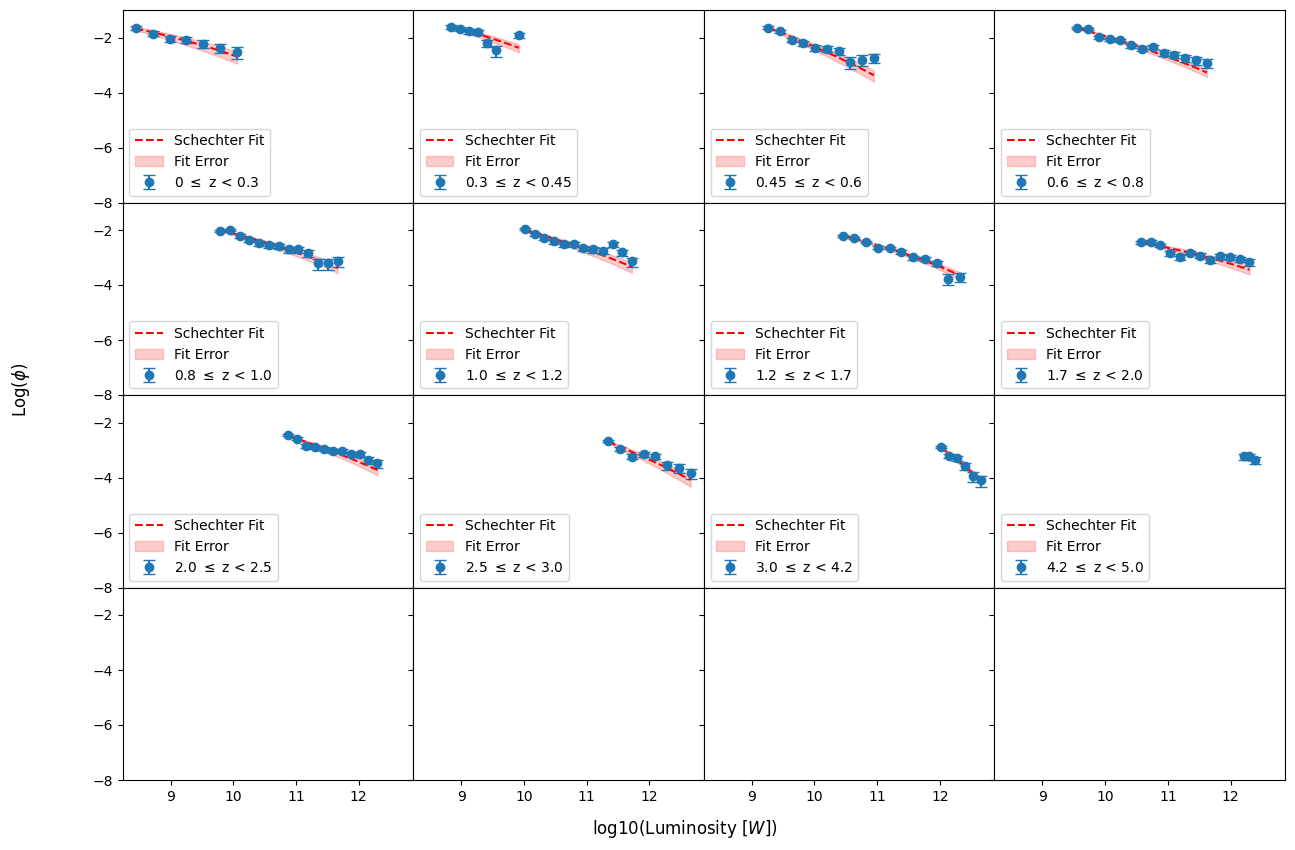

In [46]:
def schechter_luminosity(M, M_star, phi_star, alpha):
    return phi_star * 10 ** (-0.4*(1-alpha)*(M_star-M)) * np.exp(-10.**(-0.4*(M_star-M)))

schecter_params = []

fig, axes = plt.subplots(4, 4, figsize=(15, 10), sharex=True, sharey=True)
for (z_start, z_end), lum, p, e, ax in zip(redshift_bins, lum_centers, phi, phi_e, axes.flatten()):

    if len(lum) == 0:
        print(f'No data for {z_start} <= z < {z_end}')
        continue
    
    # Attempt to fit the data
    # p0=[lum[0], 0.001, -0.9]
    bounds = ([lum[0], 1e-6, 1], [lum[-1], 1e-1, 5])
    try:
        params, covars = curve_fit(schechter_luminosity, lum, p, bounds=bounds, maxfev=1000)
        p_up, _ = curve_fit(schechter_luminosity, lum, p+e, bounds=bounds, maxfev=1000)
        p_down, _ = curve_fit(schechter_luminosity, lum, p-e, bounds=bounds, maxfev=1000)
        schecter_params.append(params)
    except RuntimeError:
        print(f'Failed to fit {z_start} <= z < {z_end}. Maxfev reached.')
        schecter_params.append([])
        continue
    except TypeError:
        print(f'Failed to fit {z_start} <= z < {z_end}. Params: {len(params)} > data points: {len(lum)}.')
        schecter_params.append([])
        continue
    
    print(f'{z_start} <= z < {z_end} Function fit:')
    print(f'M_star = {params[0]:.2e}')
    print(f'phi_star = {params[1]:.2e}')
    print(f'alpha = {params[2]:.2e}')
    print('\n')
    
    # Plot the data
    yerr = [np.log10(p) - np.log10(p - e), np.log10(p + e) - np.log10(p)]
    ax.errorbar(lum, np.log10(p), yerr=yerr, label=f'{z_start} $\leq$ z < {z_end}', fmt='o', capsize=4)
    ax.plot(lum, np.log10(schechter_luminosity(lum, *params)), color='red', label='Schechter Fit', linestyle='--')
    ax.fill_between(lum,
        np.log10(schechter_luminosity(lum, *p_down)),
        np.log10(schechter_luminosity(lum, *p_up)),
        color='red', alpha=0.2, label='Fit Error')
    ax.legend(loc='lower left')
    ax.set_ylim(-8, -1)

fig.supxlabel('log10(Luminosity [$W$])', y=0.05)
fig.supylabel('Log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

### Saunders Fit

0 <= z < 0.3 Function fit:
M_star = 1.60e+01
phi_star = 1.00e-06
alpha = 2.43e+00
sigma = 1.00e-02


0.3 <= z < 0.45 Function fit:
M_star = 1.57e+01
phi_star = 1.00e-06
alpha = 2.60e+00
sigma = 1.00e-02


0.45 <= z < 0.6 Function fit:
M_star = 1.46e+01
phi_star = 1.00e-06
alpha = 3.06e+00
sigma = 1.00e-02


0.6 <= z < 0.8 Function fit:
M_star = 1.60e+01
phi_star = 1.00e-06
alpha = 2.69e+00
sigma = 1.00e-02


0.8 <= z < 1.0 Function fit:
M_star = 1.61e+01
phi_star = 1.00e-06
alpha = 2.59e+00
sigma = 1.00e-02


1.0 <= z < 1.2 Function fit:
M_star = 1.63e+01
phi_star = 1.00e-06
alpha = 2.60e+00
sigma = 1.00e-02


1.2 <= z < 1.7 Function fit:
M_star = 1.68e+01
phi_star = 1.00e-06
alpha = 2.49e+00
sigma = 5.02e-03


1.7 <= z < 2.0 Function fit:
M_star = 1.77e+01
phi_star = 1.00e-06
alpha = 2.26e+00
sigma = 1.00e-02


2.0 <= z < 2.5 Function fit:
M_star = 1.63e+01
phi_star = 1.00e-06
alpha = 2.64e+00
sigma = 1.00e-02


2.5 <= z < 3.0 Function fit:
M_star = 1.62e+01
phi_star = 1.00e-06
alpha 

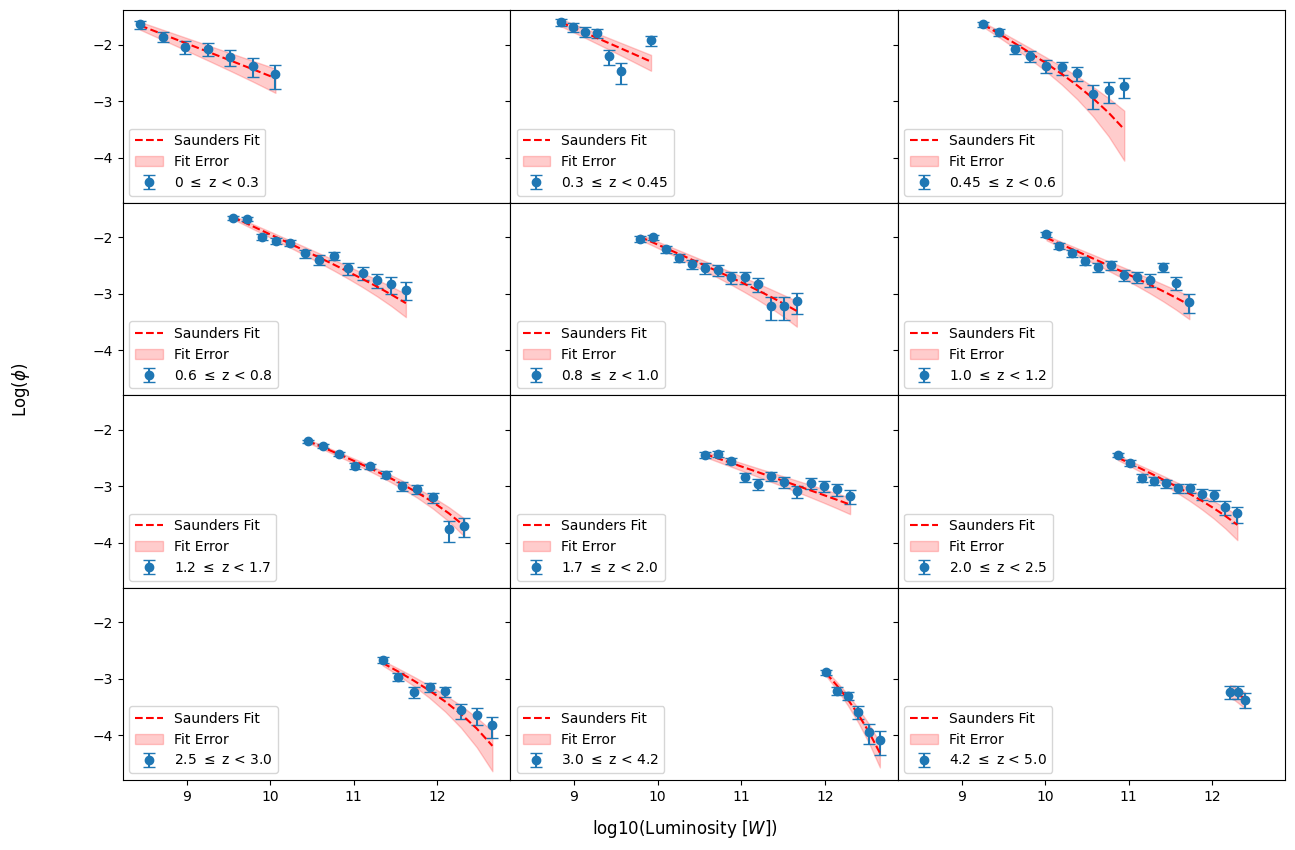

In [68]:
def saunders_luminosity(M, M_star, phi_star, alpha, sigma):
    return phi_star * 10 ** (-0.4*(1-alpha)*(M_star-M)) * np.exp(-1 / (2 * sigma ** 2) * (np.log10(1 + 10 ** (-0.4 * (M_star-M))))**2)

saunder_params = []

fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)
for (z_start, z_end), lum, p, e, ax in zip(redshift_bins, lum_centers, phi, phi_e, axes.flatten()):
    
    if len(lum) == 0:
        print(f'No data for {z_start} <= z < {z_end}')
        continue
    
    # Attempt to fit the data
    # p0 = [lum[0], 0.001, -0.9, 0.1]
    bounds = ([lum[0]/2, 1e-6, 1, 1e-6], [lum[-1]*2, 1e-2, 5, 1e-2])
    try:
        params, _ = curve_fit(saunders_luminosity, lum, p, bounds=bounds, maxfev=1000)
        p_up, _ = curve_fit(saunders_luminosity, lum, p+e, bounds=bounds, maxfev=1000)
        p_down, _ = curve_fit(saunders_luminosity, lum, p-e, bounds=bounds, maxfev=1000)
        saunder_params.append(params)
    except RuntimeError:
        print(f'Failed to fit {z_start} <= z < {z_end}. Maxfev reached.')
        saunder_params.append([])
        continue
    except TypeError:
        print(f'Failed to fit {z_start} <= z < {z_end}. Params: {len(params)} > data points: {len(lum)}.')
        saunder_params.append([])
        continue       
    
    print(f'{z_start} <= z < {z_end} Function fit:')
    print(f'M_star = {params[0]:.2e}')
    print(f'phi_star = {params[1]:.2e}')
    print(f'alpha = {params[2]:.2e}')
    print(f'sigma = {params[3]:.2e}')
    print('\n')
    
    # Plot the data
    yerr = [np.log10(p) - np.log10(p - e), np.log10(p + e) - np.log10(p)]
    ax.errorbar(lum, np.log10(p), yerr=yerr, label=f'{z_start} $\leq$ z < {z_end}', fmt='o', capsize=4)
    ax.plot(lum, np.log10(saunders_luminosity(lum, *params)), color='red', label='Saunders Fit', linestyle='--')   
    ax.fill_between(lum, 
        np.log10(saunders_luminosity(lum, *p_down)), 
        np.log10(saunders_luminosity(lum, *p_up)), 
        color='red', alpha=0.2, label='Fit Error')
    ax.legend(loc='lower left')

fig.supxlabel('log10(Luminosity [$W$])', y=0.05)
fig.supylabel('Log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

### Export

In [69]:
file_name = 'reg2_lf'
np.savez(file_name, 
    x=np.array(lum_centers, dtype=object), 
    y=np.array(phi, dtype=object), 
    e=np.array(phi_e, dtype=object),
    z=np.array(redshift_bins, dtype=object),
    m=np.array(min_ls, dtype=object),
    schech_p=np.array(schecter_params, dtype=object),
    saunder_p=np.array(saunder_params, dtype=object))